In [38]:
# @title Cell 1: Cài đặt và Import các thư viện cần thiết

!pip install xgboost -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import zipfile
import os

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier

# TensorFlow imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Model persistence
import joblib

# Set plot style
sns.set_style('whitegrid')
print("Tất cả thư viện đã được import và cài đặt thành công!")

Tất cả thư viện đã được import và cài đặt thành công!


In [39]:
# @title Cell 2: Kết nối Google Drive
# ---
# Chú thích:
# Cell này thực hiện việc kết nối Colab với Google Drive của bạn.
# Bạn sẽ cần phải xác thực quyền truy cập khi chạy cell này.
# ---
drive.mount('/content/drive')
print("Đã kết nối thành công với Google Drive!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Đã kết nối thành công với Google Drive!


In [40]:
# @title Cell 3: Giải nén file Dataset

# Đặt đường dẫn tới file zip và thư mục giải nén
zip_file_path = '/content/drive/MyDrive/Machine Learning/archive.zip'
extract_folder_path = '/content/stroke_dataset'

# Tạo thư mục nếu chưa tồn tại
if not os.path.exists(extract_folder_path):
    os.makedirs(extract_folder_path)

# Giải nén file
try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_folder_path)
    print(f"Đã giải nén thành công file vào thư mục: {extract_folder_path}")
    # Tìm tên file CSV sau khi giải nén
    csv_file_name = [f for f in os.listdir(extract_folder_path) if f.endswith('.csv')][0]
    csv_file_path = os.path.join(extract_folder_path, csv_file_name)
    print(f"Tìm thấy file CSV: {csv_file_path}")
except FileNotFoundError:
    print(f"Lỗi: Không tìm thấy file tại đường dẫn '{zip_file_path}'. Vui lòng kiểm tra lại.")
except Exception as e:
    print(f"Đã xảy ra lỗi: {e}")

Đã giải nén thành công file vào thư mục: /content/stroke_dataset
Tìm thấy file CSV: /content/stroke_dataset/healthcare-dataset-stroke-data.csv


In [41]:
# @title Cell 4: Đọc dữ liệu và xem tổng quan

try:
    df = pd.read_csv(csv_file_path)
    print("Thông tin 5 dòng đầu của dữ liệu:")
    display(df.head())
except NameError:
    print("Biến 'csv_file_path' chưa được định nghĩa. Vui lòng chạy thành công Cell 3 trước.")
except FileNotFoundError:
    print(f"Lỗi: Không tìm thấy file CSV tại đường dẫn đã giải nén. Vui lòng kiểm tra lại file zip.")

Thông tin 5 dòng đầu của dữ liệu:


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [42]:
# @title Cell 5: Phân tích thông tin cơ bản của dữ liệu

print("Thông tin chung về DataFrame:")
df.info()

print("\nThống kê mô tả cho các cột số:")
display(df.describe())

print("\nSố lượng giá trị bị thiếu (null) trong mỗi cột:")
print(df.isnull().sum())

Thông tin chung về DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB

Thống kê mô tả cho các cột số:


,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000



Số lượng giá trị bị thiếu (null) trong mỗi cột:
id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


/tmp/ipython-input-1723779195.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='stroke', data=df, palette=['skyblue', 'salmon'])


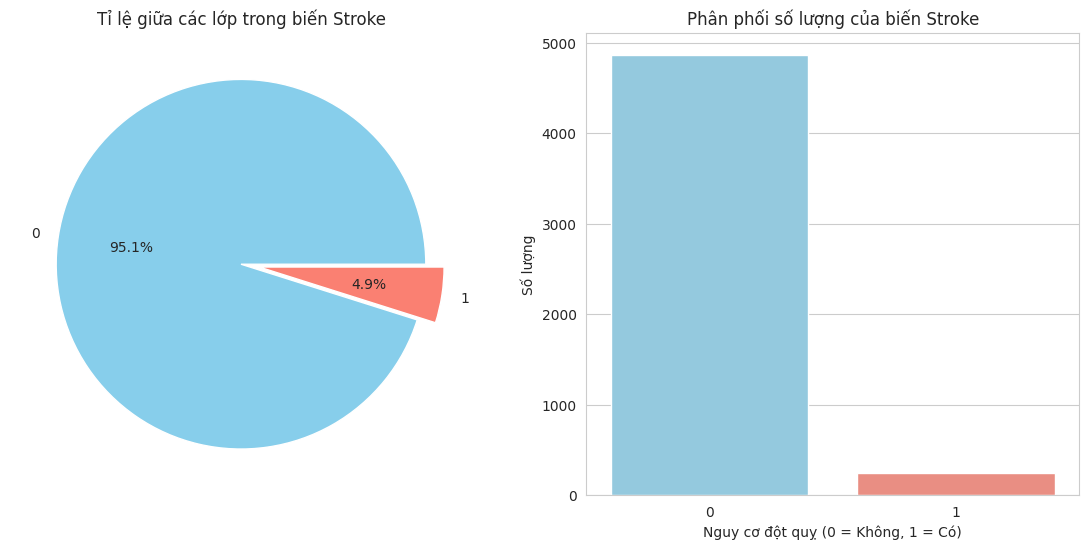

In [43]:
# @title Cell 6: Trực quan hóa tỉ lệ đột quỵ (biến mục tiêu)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
df['stroke'].value_counts().plot.pie(autopct='%1.1f%%', colors=['skyblue', 'salmon'], explode=[0, 0.1])
plt.title('Tỉ lệ giữa các lớp trong biến Stroke')
plt.ylabel('')

plt.subplot(1, 2, 2)
sns.countplot(x='stroke', data=df, palette=['skyblue', 'salmon'])
plt.title('Phân phối số lượng của biến Stroke')
plt.xlabel('Nguy cơ đột quỵ (0 = Không, 1 = Có)')
plt.ylabel('Số lượng')

plt.show()

/tmp/ipython-input-2651780256.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 1].set_xticklabels(['Không', 'Có'])
/tmp/ipython-input-2651780256.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 0].set_xticklabels(['Không', 'Có'])


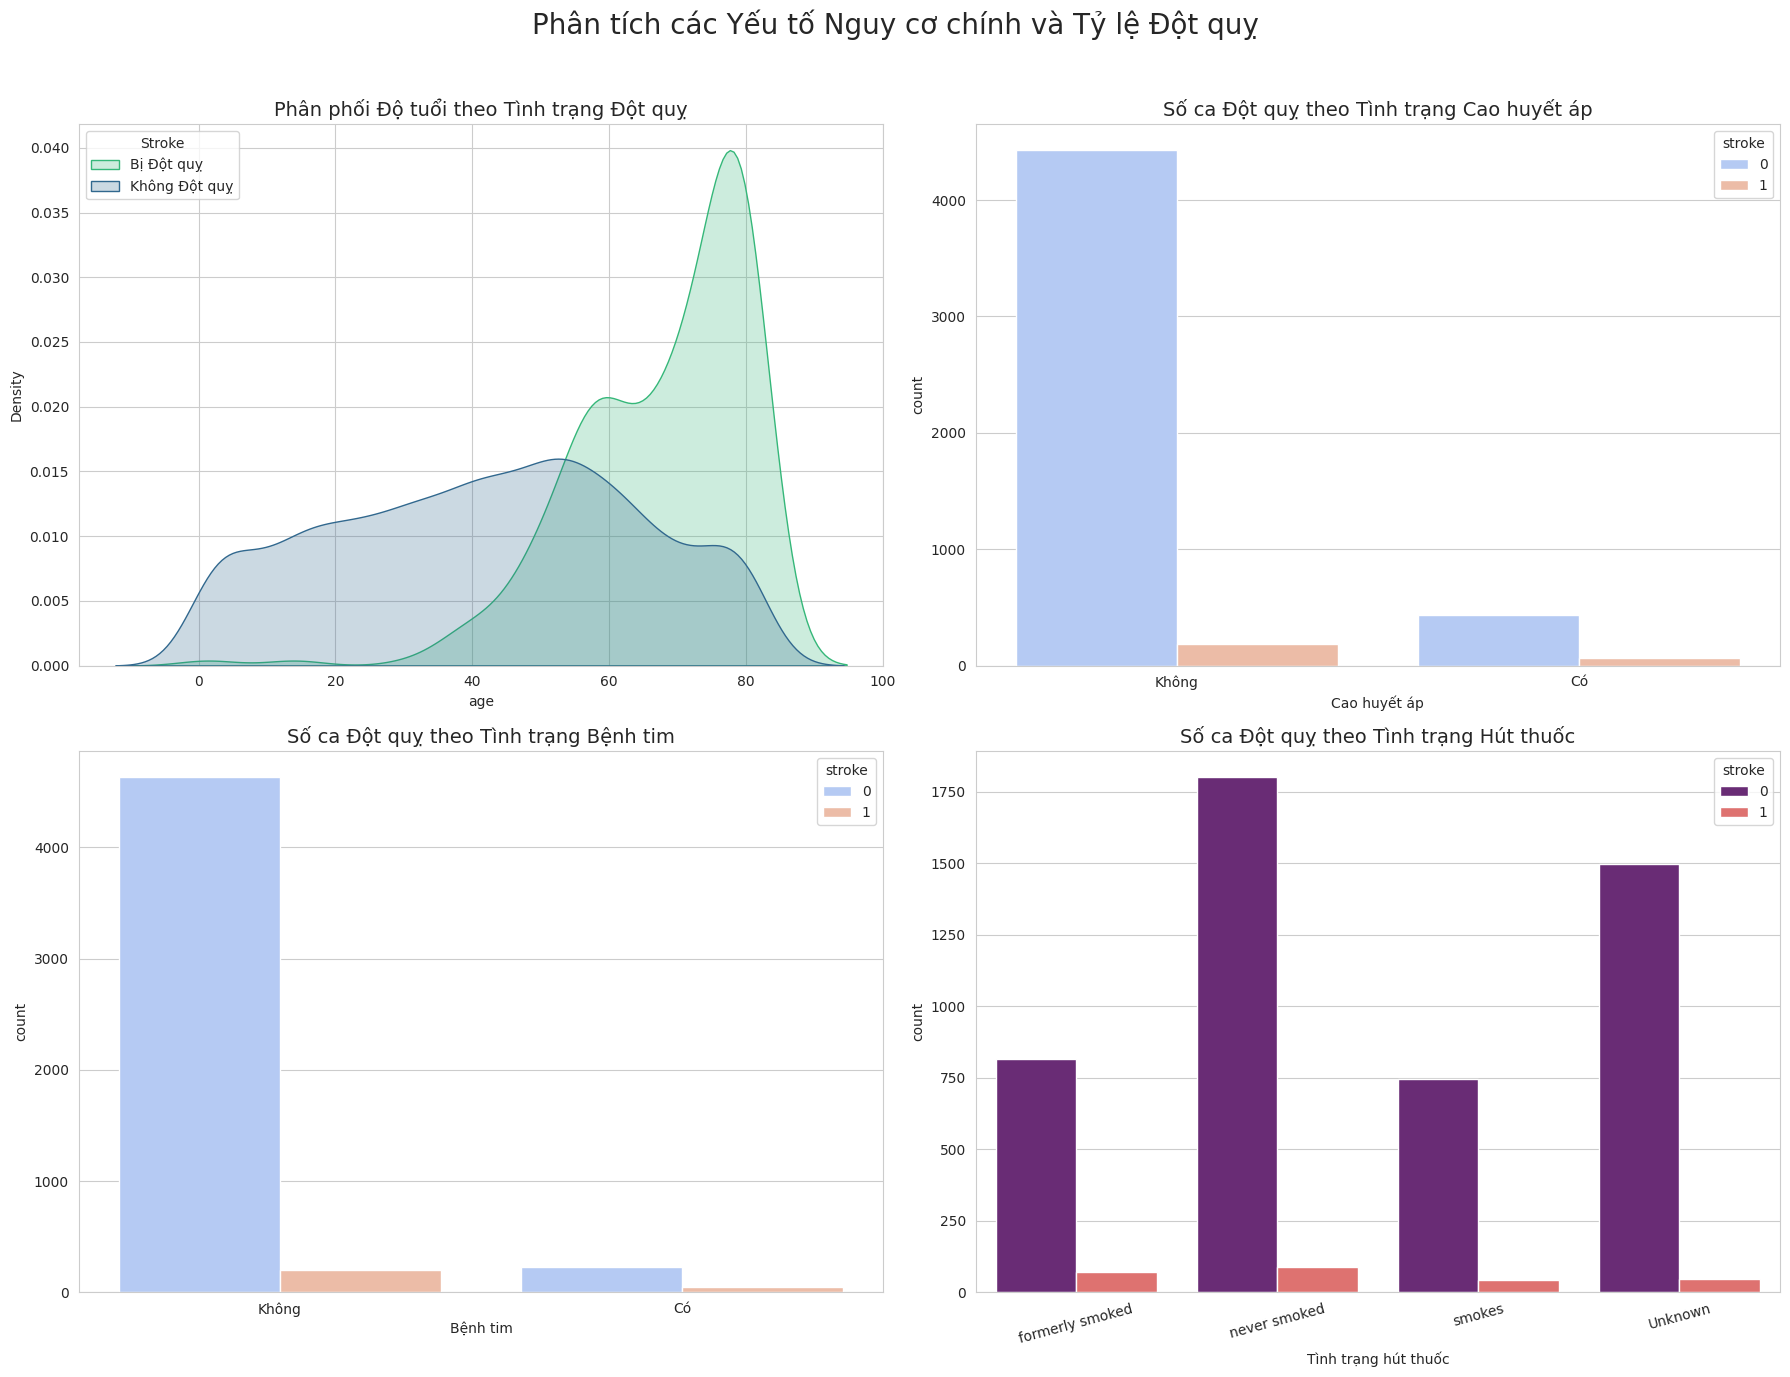


=> Nhận xét: Tuổi càng cao, nguy cơ đột quỵ càng tăng rõ rệt. Có bệnh nền (cao huyết áp, bệnh tim) và tình trạng đã từng hút thuốc cũng làm tăng số ca đột quỵ.


In [44]:
# @title Cell 7: EDA - Phân tích một số Yếu tố Nguy cơ
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Phân tích các Yếu tố Nguy cơ chính và Tỷ lệ Đột quỵ', fontsize=20)

# 1. Phân phối Độ tuổi
sns.kdeplot(data=df, x='age', hue='stroke', fill=True, common_norm=False, palette='viridis', ax=axes[0, 0])
axes[0, 0].set_title('Phân phối Độ tuổi theo Tình trạng Đột quỵ', fontsize=14)
axes[0, 0].legend(title='Stroke', labels=['Bị Đột quỵ', 'Không Đột quỵ'])

# 2. Cao huyết áp
sns.countplot(data=df, x='hypertension', hue='stroke', palette='coolwarm', ax=axes[0, 1])
axes[0, 1].set_title('Số ca Đột quỵ theo Tình trạng Cao huyết áp', fontsize=14)
axes[0, 1].set_xticklabels(['Không', 'Có'])
axes[0, 1].set_xlabel('Cao huyết áp')

# 3. Bệnh tim
sns.countplot(data=df, x='heart_disease', hue='stroke', palette='coolwarm', ax=axes[1, 0])
axes[1, 0].set_title('Số ca Đột quỵ theo Tình trạng Bệnh tim', fontsize=14)
axes[1, 0].set_xticklabels(['Không', 'Có'])
axes[1, 0].set_xlabel('Bệnh tim')

# 4. Tình trạng hút thuốc
sns.countplot(data=df, x='smoking_status', hue='stroke', palette='magma', ax=axes[1, 1])
axes[1, 1].set_title('Số ca Đột quỵ theo Tình trạng Hút thuốc', fontsize=14)
axes[1, 1].tick_params(axis='x', rotation=15)
axes[1, 1].set_xlabel('Tình trạng hút thuốc')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

print("\n=> Nhận xét: Tuổi càng cao, nguy cơ đột quỵ càng tăng rõ rệt. Có bệnh nền (cao huyết áp, bệnh tim) và tình trạng đã từng hút thuốc cũng làm tăng số ca đột quỵ.")

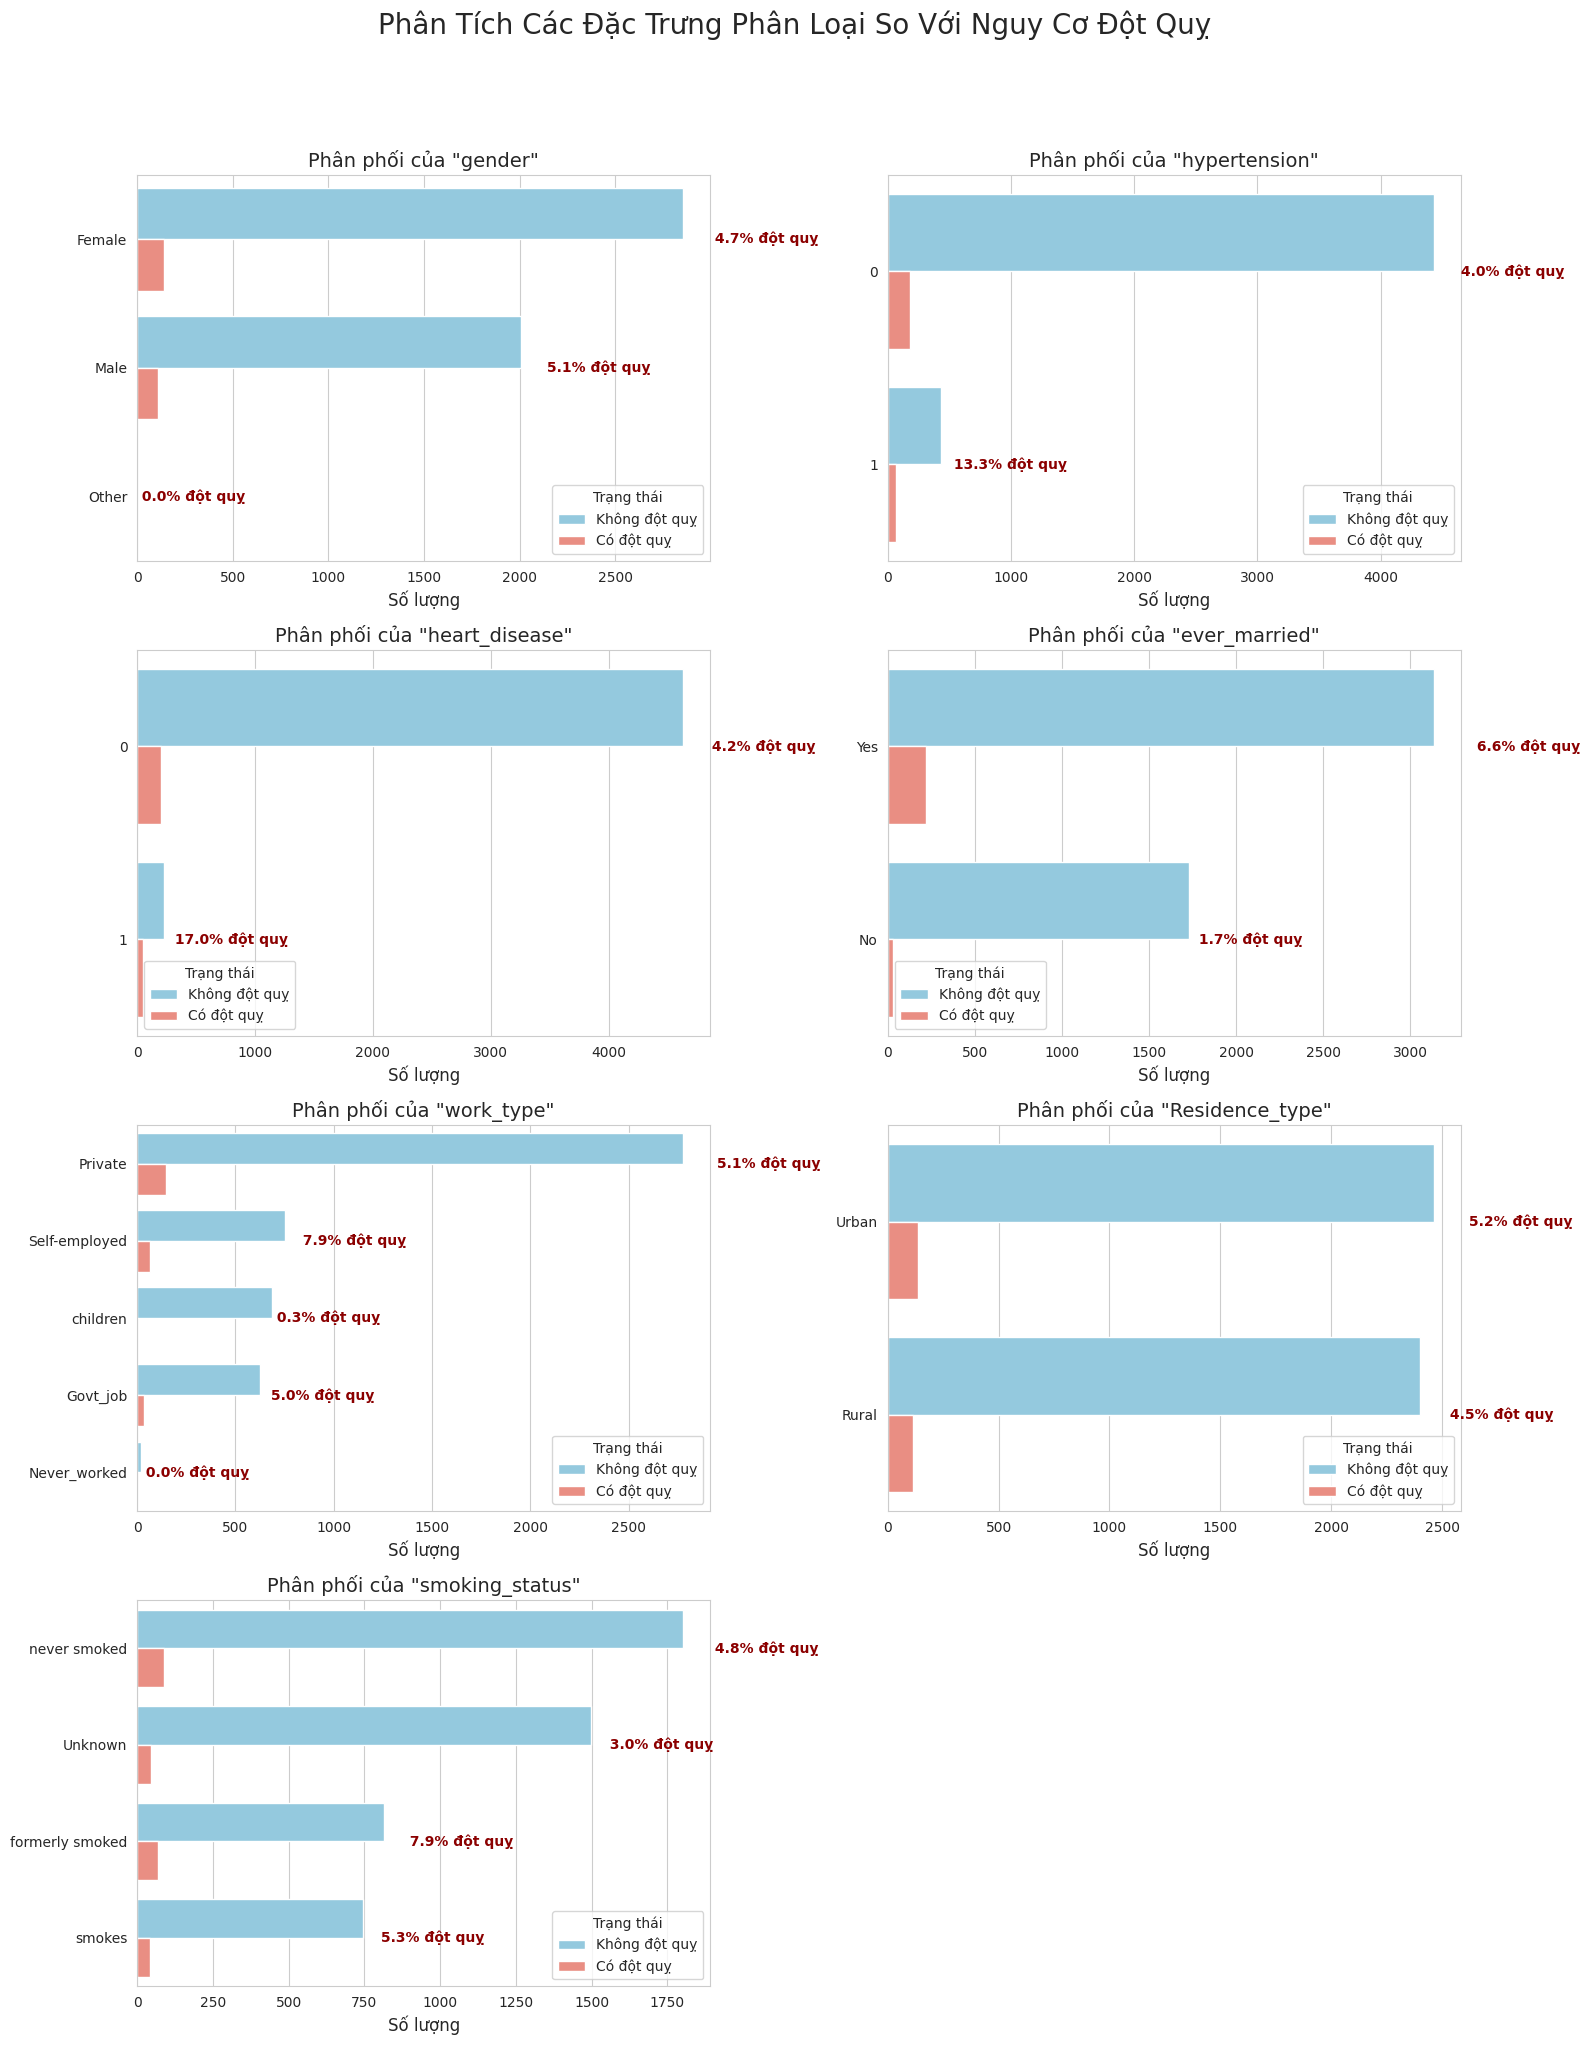

In [45]:
# @title Cell 8: Trực quan hóa các đặc trưng phân loại theo nguy cơ đột quỵ

categorical_features = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

# Tự động tính toán số lượng hàng và cột cho subplot
n_features = len(categorical_features)
n_cols = 2
n_rows = (n_features + n_cols - 1) // n_cols  # Công thức làm tròn lên

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 5))
axes = axes.flatten()

# Định nghĩa màu sắc có chủ đích
palette = {0: 'skyblue', 1: 'salmon'}

# Thêm tiêu đề chính cho toàn bộ hình
fig.suptitle('Phân Tích Các Đặc Trưng Phân Loại So Với Nguy Cơ Đột Quỵ', fontsize=20, y=1.02)

for i, col in enumerate(categorical_features):
    ax = axes[i]

    # Sắp xếp các thanh theo thứ tự số lượng giảm dần
    order = df[col].value_counts().index

    # Vẽ biểu đồ countplot với `hue` là biến mục tiêu
    sns.countplot(data=df, y=col, hue='stroke', ax=ax, palette=palette, order=order)

    # --- Thêm chú thích tỉ lệ % đột quỵ (phần quan trọng nhất) ---
    # Lặp qua từng loại trong cột (ví dụ: 'Male', 'Female' trong 'gender')
    for index, category in enumerate(order):
        # Lấy tổng số mẫu trong loại đó
        total_in_category = len(df[df[col] == category])
        # Lấy số mẫu bị đột quỵ trong loại đó
        stroke_in_category = len(df[(df[col] == category) & (df['stroke'] == 1)])

        if total_in_category > 0:
            # Tính toán tỉ lệ %
            percentage_stroke = (stroke_in_category / total_in_category) * 100
            # Định vị và viết text lên biểu đồ
            ax.text(
                x=total_in_category,      # Vị trí x: ở cuối thanh tổng
                y=index,                  # Vị trí y: ngang với thanh hiện tại
                s=f' {percentage_stroke:.1f}% đột quỵ', # Nội dung text
                va='center',              # Căn giữa theo chiều dọc
                ha='left',                # Căn lề trái
                color='darkred',
                fontweight='bold',
                fontsize=10
            )

    ax.set_title(f'Phân phối của "{col}"', fontsize=14)
    ax.set_ylabel('') # Bỏ nhãn trục y để gọn gàng hơn
    ax.set_xlabel('Số lượng', fontsize=12)

    # Cập nhật legend cho dễ hiểu
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, ['Không đột quỵ', 'Có đột quỵ'], title='Trạng thái')

# Ẩn các subplot không sử dụng (nếu có)
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

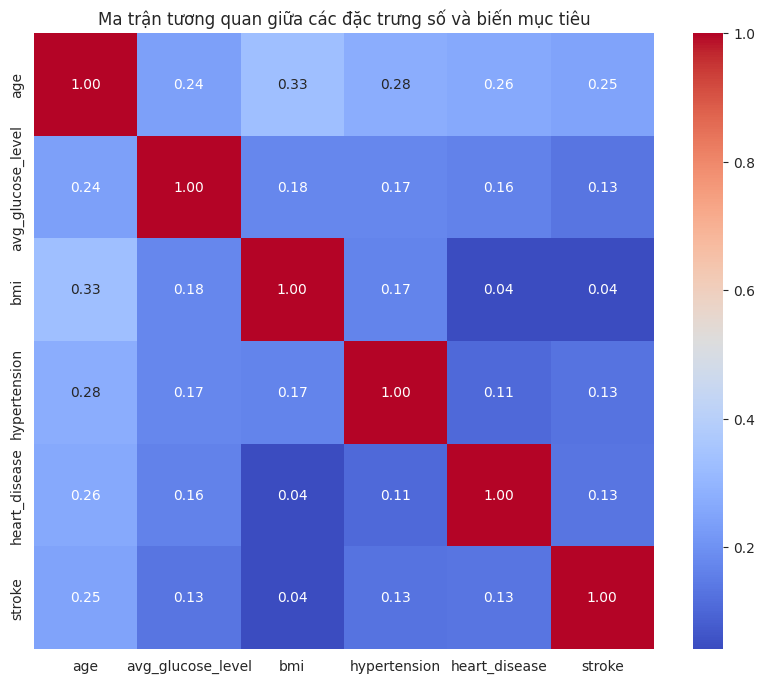

In [46]:
# @title Cell 9: Trực quan hóa ma trận tương quan (Đã sửa lỗi)

# Thêm dòng này để định nghĩa biến 'numerical_features'
numerical_features = ['age', 'avg_glucose_level', 'bmi']

plt.figure(figsize=(10, 8))
# Tạm thời mã hóa các biến nhị phân để đưa vào ma trận tương quan
df_corr = df.copy()
for col in ['hypertension', 'heart_disease', 'stroke']:
    df_corr[col] = df_corr[col].astype(int)

# Dòng code bên dưới sẽ không còn báo lỗi
correlation_matrix = df_corr[numerical_features + ['hypertension', 'heart_disease', 'stroke']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Ma trận tương quan giữa các đặc trưng số và biến mục tiêu')
plt.show()

In [47]:
# @title Cell 10: Xử lý dữ liệu
# ---
# Chú thích:
# - Loại bỏ cột 'id' không cần thiết.
# - Xử lý giá trị 'Other' trong cột 'gender' (vì chỉ có 1 mẫu, ta có thể loại bỏ).
# - Điền giá trị thiếu trong cột 'bmi' bằng giá trị trung vị (median)
#   vì phân phối của BMI hơi lệch.
# ---
# Bỏ cột ID
df = df.drop('id', axis=1)

# Xử lý 'gender'
df = df[df['gender'] != 'Other']

# Điền giá trị thiếu cho BMI
imputer = SimpleImputer(strategy='median')
df['bmi'] = imputer.fit_transform(df[['bmi']])

print("Đã xử lý xong các giá trị thiếu và không hợp lệ.")
print("\nKiểm tra lại số lượng giá trị thiếu:")
print(df.isnull().sum())

Đã xử lý xong các giá trị thiếu và không hợp lệ.

Kiểm tra lại số lượng giá trị thiếu:
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64


In [48]:
# @title Cell 11: Chia dữ liệu thành tập Train và Test

X = df.drop('stroke', axis=1)
y = df['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Kích thước tập huấn luyện: {X_train.shape}")
print(f"Kích thước tập kiểm thử: {X_test.shape}")

Kích thước tập huấn luyện: (4087, 10)
Kích thước tập kiểm thử: (1022, 10)


In [49]:
# @title Cell 12: Xây dựng Pipeline để mã hóa và chuẩn hóa
# ---
# Chú thích:
# Tạo một pipeline để tự động hóa quá trình tiền xử lý:
# - Đối với các đặc trưng số: Chuẩn hóa bằng StandardScaler.
# - Đối với các đặc trưng phân loại: Mã hóa bằng OneHotEncoder.
# Điều này đảm bảo rằng các bước xử lý được áp dụng nhất quán
# cho cả tập train và test.
# ---
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

# Pipeline cho các cột số
numerical_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Pipeline cho các cột phân loại
categorical_pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Kết hợp hai pipeline trên bằng ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_cols),
        ('cat', categorical_pipeline, categorical_cols)
    ],
    remainder='passthrough'
)

# Áp dụng preprocessor
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print("Đã xử lý và chuẩn hóa dữ liệu thành công!")

Đã xử lý và chuẩn hóa dữ liệu thành công!


In [50]:
# @title Cell 13: Huấn luyện các mô hình cơ bản

from sklearn.svm import SVC

models = {}

# 1. Logistic Regression
print("Đang huấn luyện Logistic Regression...")
lr_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', LogisticRegression(random_state=42, solver='liblinear'))])
lr_pipeline.fit(X_train, y_train)
models['Logistic Regression'] = lr_pipeline

# 2. Random Forest
print("Đang huấn luyện Random Forest...")
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))])
rf_pipeline.fit(X_train, y_train)
models['Random Forest'] = rf_pipeline

# 3. XGBoost
print("Đang huấn luyện XGBoost...")
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', XGBClassifier(random_state=42, use_label_encoder=False,
                                                            eval_metric='logloss', scale_pos_weight=scale_pos_weight))])
xgb_pipeline.fit(X_train, y_train)
models['XGBoost'] = xgb_pipeline

# 4. Support Vector Machine (SVC)
print("Đang huấn luyện Support Vector Machine...")
svm_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', SVC(random_state=42, class_weight='balanced', probability=True))])
svm_pipeline.fit(X_train, y_train)
models['Support Vector Machine'] = svm_pipeline

print("\nĐã huấn luyện xong các mô hình cơ bản!")

Đang huấn luyện Logistic Regression...
Đang huấn luyện Random Forest...
Đang huấn luyện XGBoost...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [03:04:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Đang huấn luyện Support Vector Machine...

Đã huấn luyện xong các mô hình cơ bản!


In [51]:
# @title Cell 14: Xây dựng các mô hình Ensemble

# Lấy các mô hình cơ sở từ pipeline để dùng trong ensemble
clf1 = models['Logistic Regression'].named_steps['classifier']
clf2 = models['Random Forest'].named_steps['classifier']
clf3 = models['XGBoost'].named_steps['classifier']
clf4 = models['Support Vector Machine'].named_steps['classifier']

# 1. Voting Classifier
print("Đang xây dựng Voting Classifier...")

voting_clf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('xgb', clf3), ('svc', clf4)], voting='soft')
voting_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', voting_clf)])
voting_pipeline.fit(X_train, y_train)
models['Ensemble Voting'] = voting_pipeline

# 2. Stacking Classifier
print("Đang xây dựng Stacking Classifier...")

stacking_clf = StackingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('xgb', clf3), ('svc', clf4)],
                                  final_estimator=LogisticRegression(), cv=5)
stacking_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', stacking_clf)])
stacking_pipeline.fit(X_train, y_train)
models['Ensemble Stacking'] = stacking_pipeline

print("\nĐã xây dựng xong các mô hình ensemble!")

Đang xây dựng Voting Classifier...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [03:04:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Đang xây dựng Stacking Classifier...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [03:04:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [03:04:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Đã xây dựng xong các mô hình ensemble!


In [52]:
# @title Cell 15: Đánh giá và so sánh tất cả các mô hình

results = []

# Vòng lặp bây giờ đơn giản hơn rất nhiều
for name, model in models.items():
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    results.append({'Model': name, 'Accuracy': accuracy, 'F1 Score': f1, 'ROC-AUC': roc_auc})

results_df = pd.DataFrame(results).sort_values(by='ROC-AUC', ascending=False)
results_df.set_index('Model', inplace=True)

print("Bảng so sánh hiệu suất các mô hình:")
display(results_df.style.background_gradient(cmap='Greens'))

Bảng so sánh hiệu suất các mô hình:


,Accuracy,F1 Score,ROC-AUC
Model,,,
Logistic Regression,0.952055,0.039216,0.839033
Ensemble Stacking,0.950098,0.037736,0.824815
Ensemble Voting,0.950098,0.000000,0.810000
Support Vector Machine,0.747554,0.208589,0.789897
Random Forest,0.949119,0.000000,0.772037
XGBoost,0.915851,0.203704,0.761152


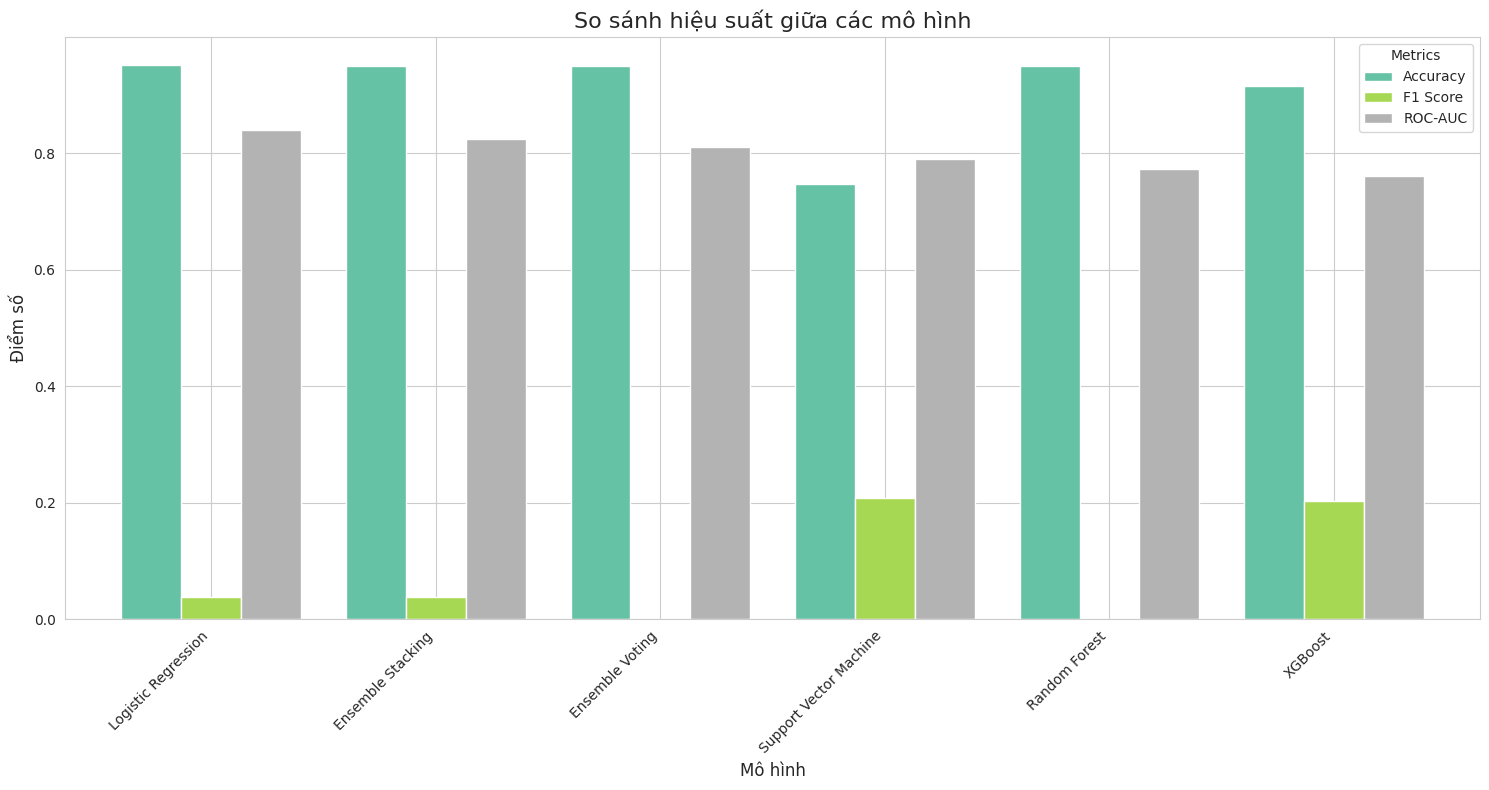

In [53]:
# @title Cell 16: Trực quan hóa kết quả so sánh

results_df.plot(kind='bar', figsize=(15, 8), colormap='Set2', width=0.8)

plt.title('So sánh hiệu suất giữa các mô hình', fontsize=16)
plt.ylabel('Điểm số', fontsize=12)
plt.xlabel('Mô hình', fontsize=12)
plt.xticks(rotation=45, ha='right') # Chỉnh lại góc xoay để không bị che
plt.legend(title='Metrics')
plt.tight_layout() # Tự động điều chỉnh để các thành phần không bị đè lên nhau
plt.show()

/tmp/ipython-input-618492896.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='coolwarm')


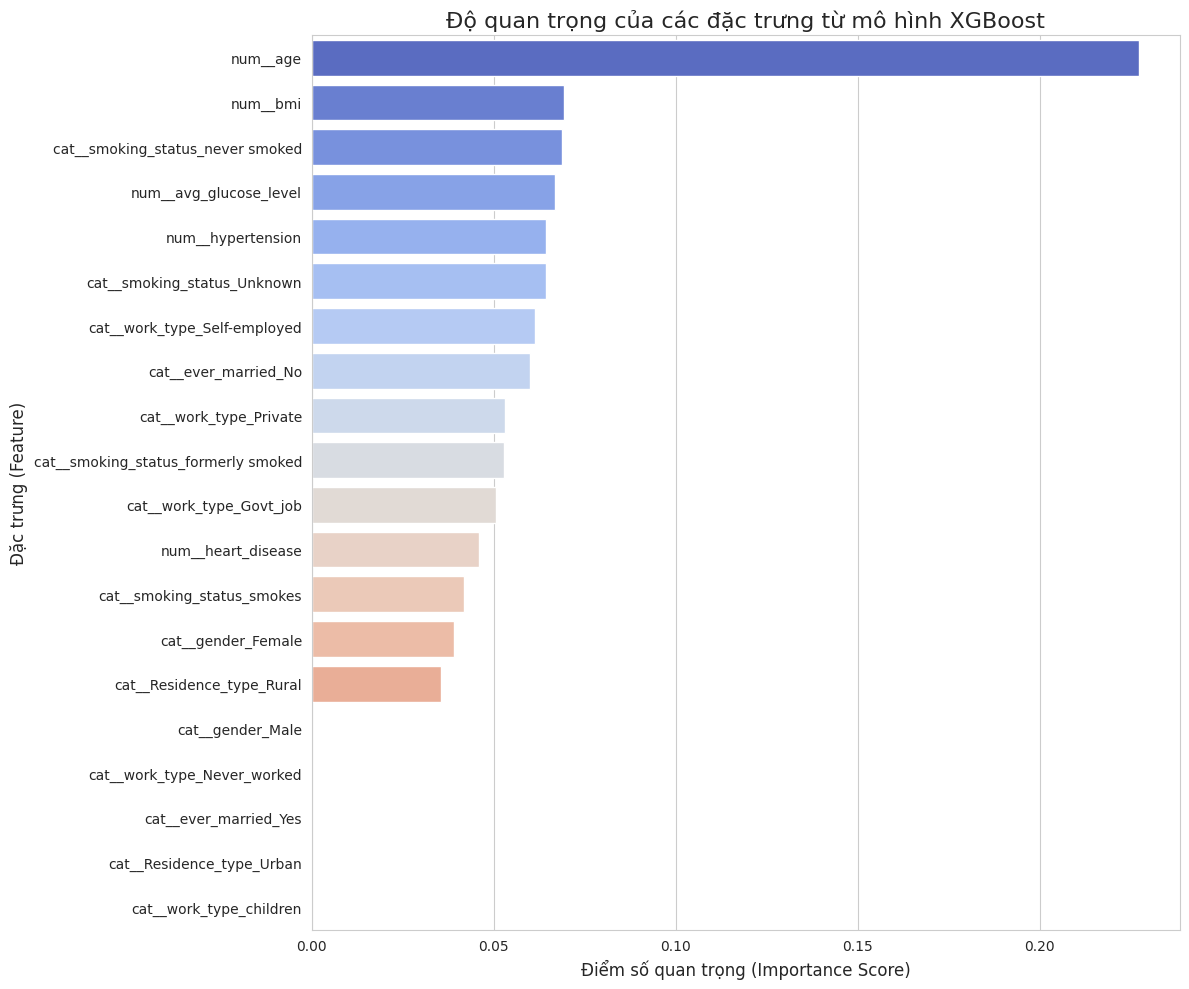


Top 10 đặc trưng quan trọng nhất:


,Feature,Importance
0,num__age,0.227129
4,num__bmi,0.069190
18,cat__smoking_status_never smoked,0.068626
3,num__avg_glucose_level,0.066792
1,num__hypertension,0.064231
16,cat__smoking_status_Unknown,0.064230
12,cat__work_type_Self-employed,0.061375
7,cat__ever_married_No,0.059850
11,cat__work_type_Private,0.053040
17,cat__smoking_status_formerly smoked,0.052674


In [54]:
# @title Cell 16.5: Trực quan hóa độ quan trọng của các đặc trưng
# ---
# Chú thích:
# Việc hiểu đặc trưng nào có ảnh hưởng lớn nhất đến dự đoán của mô hình là rất quan trọng.
# Cell này sẽ lấy mô hình XGBoost đã huấn luyện, trích xuất điểm số quan trọng
# của từng đặc trưng và vẽ biểu đồ để so sánh.
# Điều này giúp ta biết được các yếu tố như 'tuổi', 'mức đường huyết', 'chỉ số BMI'
# ảnh hưởng đến nguy cơ đột quỵ như thế nào theo góc nhìn của mô hình.
# ---

# Chọn một mô hình để phân tích (XGBoost thường cho kết quả rất tốt)
model_to_analyze_name = 'XGBoost'
pipeline = models[model_to_analyze_name]

# Lấy ra bước classifier (mô hình) và preprocessor từ pipeline
try:
    classifier = pipeline.named_steps['classifier']
    preprocessor = pipeline.named_steps['preprocessor']
except KeyError:
    print(f"Lỗi: Không tìm thấy các bước 'classifier' hoặc 'preprocessor' trong pipeline '{model_to_analyze_name}'.")
    # Dừng thực thi nếu có lỗi
    raise

# Lấy danh sách tên các đặc trưng SAU KHI đã được xử lý (ví dụ: one-hot encoding)
# Đây là bước quan trọng để tên đặc trưng khớp với điểm số importance
try:
    feature_names = preprocessor.get_feature_names_out()
except Exception as e:
    print(f"Lỗi khi lấy tên đặc trưng: {e}")
    raise

# Lấy điểm số quan trọng của các đặc trưng từ mô hình
importances = classifier.feature_importances_

# Tạo một DataFrame để dễ dàng sắp xếp và vẽ biểu đồ
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Trực quan hóa
plt.figure(figsize=(12, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='coolwarm')
plt.title(f'Độ quan trọng của các đặc trưng từ mô hình {model_to_analyze_name}', fontsize=16)
plt.xlabel('Điểm số quan trọng (Importance Score)', fontsize=12)
plt.ylabel('Đặc trưng (Feature)', fontsize=12)
plt.tight_layout()
plt.show()

# In ra 10 đặc trưng quan trọng nhất
print("\nTop 10 đặc trưng quan trọng nhất:")
display(feature_importance_df.head(10))

In [55]:
# @title Cell 17: Lưu lại mô hình tốt nhất
# ---
# Chú thích:
# Dựa trên bảng kết quả, chọn ra mô hình có hiệu suất tốt nhất
# và lưu lại vào một file (.joblib) để có thể tái sử dụng sau này
# mà không cần huấn luyện lại.
# ---
best_model_name = results_df.index[0]
best_model = models[best_model_name]

# Lưu mô hình
model_filename = '/content/drive/MyDrive/Machine Learning/streamlit/best_stroke_prediction_model.joblib'
joblib.dump(best_model, model_filename)

print(f"Đã lưu mô hình tốt nhất ('{best_model_name}') vào file '{model_filename}'")

Đã lưu mô hình tốt nhất ('Logistic Regression') vào file '/content/drive/MyDrive/Machine Learning/streamlit/best_stroke_prediction_model.joblib'
